In [47]:
# Импорт библиотек
import geopandas as gpd
import shapely.geometry
import shapely.ops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import numpy as np
from pyproj import CRS, Transformer

# --- Глобальные константы ---

# Параметры для разных типов объектов
OBJECT_TYPES = {
    "residential": {
        "density": 0.3,
        "min_distance": 15,
        "building_size": 10,
        "color": "red"
    },
    "commercial": {
        "density": 0.1,
        "min_distance": 20,
        "building_size": 15,
        "color": "blue"
    },
     "park": {
        "density": 0.2,
        "min_distance": 5,
        "building_size": 5,
        "color": "green"
    }
}

# CRS (системы координат)
CRS_WGS84 = CRS("EPSG:4326")
CRS_UTM = CRS("EPSG:32637")

# Максимальное расстояние до дороги
MAX_ROAD_DISTANCE = 100  # в метрах

# Типы дорог (для иерархии)
ROAD_TYPES = {
    "main": {
        "width": 7
    },
    "secondary": {
        "width": 5,
        "k_neighbors": 3,
        "random_weight_factor": 0.5,  # <--- УВЕЛИЧИЛИ
        "intersection_radius": 7
    },
    "local": {
        "width": 2
    }
}


In [48]:
# --- Загрузка данных ---

# Путь к файлу с входными данными
input_file = "./data/input.geojson"

# Чтение файла GeoJSON
try:
    data = gpd.read_file(input_file)
except FileNotFoundError:
    print(f"Ошибка: Файл {input_file} не найден.")
    exit()


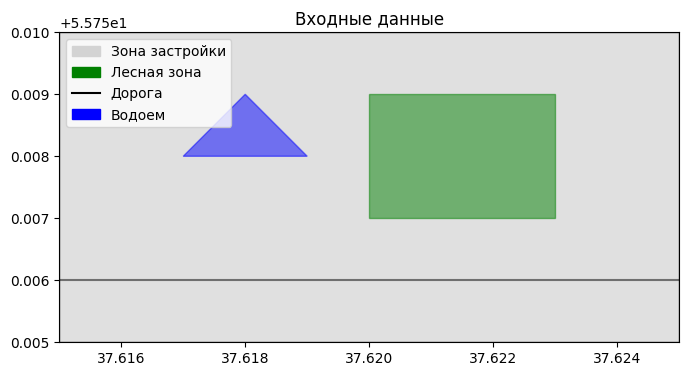

In [49]:
# --- Визуализация входных данных ---

fig, ax = plt.subplots(figsize=(8, 8))

# Отрисовка зоны застройки
buildable_area_series = data[data['id'] == 'buildable_area']
for geom in buildable_area_series.geometry:
    if isinstance(geom, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(geom.exterior.coords), facecolor='lightgray', edgecolor='black', alpha=0.7)
        ax.add_patch(polygon)

# Добавляем label вручную
buildable_area_patch = mpatches.Patch(color='lightgray', label='Зона застройки')


# Отрисовка зон с ограничениями
restricted_areas_series = data[data['restriction'] == 'no_build']
legend_handles = [buildable_area_patch] # список для ручного добавления в легенду

for index, row in restricted_areas_series.iterrows():
    #  Выбираем цвет в зависимости от типа зоны
    if row['id'] == 'forest':
        color = 'green'
    elif row['id'] == 'road':
        color = 'black'
    elif row['id'] == 'water':
        color = 'blue'
    else:
        color = 'red' # Если вдруг неизвестный тип

    geom = row['geometry']
    if isinstance(geom, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(geom.exterior.coords), color=color, alpha=0.5)
        ax.add_patch(polygon)
        legend_handles.append(mpatches.Patch(color=color, label=row['name']))
    elif isinstance(geom, shapely.geometry.LineString):
        line = mlines.Line2D(*zip(*geom.coords), color=color, alpha=0.5)
        ax.add_line(line)
        legend_handles.append(mlines.Line2D([0], [0], color=color, label=row['name']))


# Добавление легенды
plt.legend(handles=legend_handles)

plt.title("Входные данные")

# Установка пределов осей (важно для корректного отображения)
minx, miny, maxx, maxy = data.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

#  Сохраняем соотношение сторон!
ax.set_aspect('equal')

plt.show()
plt.close(fig) #  <--- ДОБАВИЛИ


In [50]:
# --- Предобработка данных ---

# Проверка геометрий на корректность
for index, row in data.iterrows():
    if not row['geometry'].is_valid:
        print(f"Warning: Некорректная геометрия в строке {index}")
        # Исправление геометрии (если возможно)
        data.loc[index, 'geometry'] = row['geometry'].buffer(0)

# Получение зоны застройки
buildable_area = data[data['id'] == 'buildable_area']
if buildable_area.empty:
    print("Ошибка: Зона застройки не найдена.")
    exit()
buildable_area = buildable_area.geometry.union_all()
if not isinstance(buildable_area, shapely.geometry.Polygon):
    if isinstance(buildable_area, shapely.geometry.MultiPolygon):
        print("Warning: Зона застройки состоит из нескольких полигонов.")
        # Выбираем самый большой полигон, если их несколько
        buildable_area = max(buildable_area.geoms, key=lambda a: a.area)
    else:
        print("Ошибка: Зона застройки имеет некорректный тип")
        exit()


# Получение зон с ограничениями (включая главную дорогу)
restricted_areas = data[data['restriction'] == 'no_build']
restricted_areas = restricted_areas.geometry.union_all()

# Получение главной дороги (теперь отдельно)
main_road = data[data['id'] == 'road']
if main_road.empty:
    print("Ошибка: Главная дорога не найдена.")
    exit()
main_road = main_road.geometry.union_all()  #  <--- ИСПРАВИЛИ
# Проверка типа
if not isinstance(main_road, shapely.geometry.LineString) and not isinstance(main_road, shapely.geometry.MultiLineString):
    print("Ошибка: главная дорога имеет неверный тип")
    exit()


In [51]:
# --- Параметры застройки (используем глобальные константы) ---

# Создаем трансформер для перевода из WGS 84 в UTM и обратно
transformer_to_utm = Transformer.from_crs(CRS_WGS84, CRS_UTM, always_xy=True)
transformer_from_utm = Transformer.from_crs(CRS_UTM, CRS_WGS84, always_xy=True)

# Функции для перевода координат (можно оставить в этой ячейке)
def to_utm(lon, lat):
    return transformer_to_utm.transform(lon, lat)

def from_utm(x, y):
    return transformer_from_utm.transform(x, y)

#  Переводим метры в градусы для КАЖДОГО типа, используя pyproj
#  Результат сохраняем *в новый словарь*, чтобы не портить константу
object_types_params = {}  #  Новый словарь для параметров с градусами
for obj_type, params in OBJECT_TYPES.items():
    object_types_params[obj_type] = params.copy() # Копируем, чтобы не изменить исходный словарь

    #Берем среднюю точку участка для перевода
    center_lon, center_lat = buildable_area.centroid.x, buildable_area.centroid.y
    #Переводим в UTM
    center_x, center_y = to_utm(center_lon, center_lat)

    #Сдвигаемся на нужное расстояние в метрах
    x_dist = center_x + params["min_distance"]
    y_dist = center_y + params["building_size"]

    #Переводим обратно в WGS84
    lon_dist, lat_dist = from_utm(x_dist, y_dist)

    #Вычисляем разницу в градусах
    object_types_params[obj_type]["min_distance_deg"] =  max(abs(lon_dist - center_lon), abs(lat_dist - center_lat))
    object_types_params[obj_type]["building_size_deg"] = max(abs(lon_dist - center_lon), abs(lat_dist - center_lat))

#Переводим MAX_ROAD_DISTANCE в градусы (аналогично)
center_lon, center_lat = buildable_area.centroid.x, buildable_area.centroid.y
center_x, center_y = to_utm(center_lon, center_lat)
x_dist = center_x + MAX_ROAD_DISTANCE
#y_dist = center_y + ROAD_WIDTH  #  Убрали, ширина теперь отдельно

lon_dist, lat_dist = from_utm(x_dist, center_y)
max_road_distance_deg = max(abs(lon_dist - center_lon), abs(lat_dist- center_lat))

#  Переводим ширину дорог в градусы (для разных типов дорог)
for road_type, road_params in ROAD_TYPES.items():
    center_x, center_y = to_utm(center_lon, center_lat) #Переводим в UTM
    y_dist = center_y + road_params["width"] #Сдвигаемся
    lon_dist, lat_dist = from_utm(center_x, y_dist) #Переводим в WGS
    ROAD_TYPES[road_type]["width_deg"] = max(abs(lon_dist - center_lon), abs(lat_dist - center_lat)) #Сохраняем в ROAD_TYPES
    if "intersection_radius" in road_params: #Если есть радиус
        y_dist = center_y + road_params["intersection_radius"]
        lon_dist, lat_dist = from_utm(center_x, y_dist)
        ROAD_TYPES[road_type]["intersection_radius_deg"] = max(abs(lon_dist - center_lon), abs(lat_dist - center_lat))

#  УДАЛЯЕМ  road_width_deg (устаревшая переменная)


In [52]:
# --- Создание сетки ---

# Границы зоны застройки
min_x, min_y, max_x, max_y = buildable_area.bounds

# Шаг сетки
max_building_size_deg = max([params["building_size_deg"] for params in object_types_params.values()])
max_min_distance_deg = max([params["min_distance_deg"] for params in object_types_params.values()])
grid_step = max(max_building_size_deg, max_min_distance_deg)  # <--- ИЗМЕНИЛИ

# Создание сетки точек
grid_points = []
x_coords = np.arange(min_x, max_x, grid_step)
y_coords = np.arange(min_y, max_y, grid_step)

for x in x_coords:
    for y in y_coords:
        point = shapely.geometry.Point(x, y)
        grid_points.append(point)

# Преобразование списка точек в GeoSeries
grid_points = gpd.GeoSeries(grid_points)


In [53]:
# --- Фильтрация сетки ---

#  Удаляем точки, если здание в этой точке выходит за границы или пересекается с запретными зонами
#  (с учетом building_size_deg - используем максимальный)
max_building_size_deg = max([params["building_size_deg"] for params in object_types_params.values()])

filtered_grid_points = []
for point in grid_points:
    building = shapely.geometry.box(point.x - max_building_size_deg / 2,
                                      point.y - max_building_size_deg / 2,
                                      point.x + max_building_size_deg / 2,
                                      point.y + max_building_size_deg / 2)
    if building.within(buildable_area) and (restricted_areas is None or not building.intersects(restricted_areas)):
        filtered_grid_points.append(point)


grid_points = gpd.GeoSeries(filtered_grid_points)
print(f"Количество точек после фильтрации: {len(grid_points)}")


Количество точек после фильтрации: 334


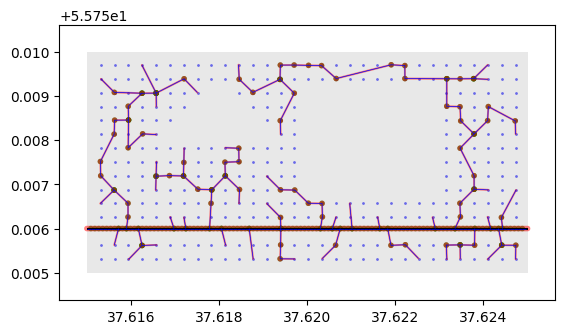

In [57]:
# --- Размещение дорог (Вариант 2: Минимальное остовное дерево (MST) на k-NN графе со случайными весами) ---
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from itertools import combinations

# --- Второстепенные дороги (MST) ---

# 1. Создаем граф
graph = nx.Graph()

#  Прореживание точек сетки (ДОБАВИЛИ)
grid_points_thinned = grid_points[::3]  # Берем каждую третью точку

# 2. Добавляем вершины (точки сетки)
points_list = list(grid_points_thinned)
#  Добавляем "шум" к координатам точек (ИЗМЕНИЛИ)
noisy_points = []  #  Список для точек с "шумом"
noise_factor = ROAD_TYPES["secondary"]["width_deg"] / 4
for point in points_list:
    new_x = point.x + np.random.uniform(-noise_factor, noise_factor)
    new_y = point.y + np.random.uniform(-noise_factor, noise_factor)
    noisy_points.append(shapely.geometry.Point(new_x, new_y))  #  Создаем НОВУЮ точку

for point in noisy_points:  #  Используем точки с "шумом"
    graph.add_node(point, pos=(point.x, point.y))

# 3. Добавляем вершины (точки на главной дороге)
road_points = []
for i in np.arange(0, main_road.length, ROAD_TYPES["secondary"]["width_deg"] * 2):
    point = main_road.interpolate(i)
    graph.add_node(point, pos=(point.x, point.y))
    road_points.append(point)

# 4. Строим k-NN граф
coords = np.array([[p.x, p.y] for p in graph.nodes])
knn = NearestNeighbors(n_neighbors=ROAD_TYPES["secondary"]["k_neighbors"] + 1)
knn.fit(coords)
distances, indices = knn.kneighbors(coords)

# 5. Добавляем ребра (с учетом k-NN и случайных весов)
for i, point in enumerate(graph.nodes):
    for j in range(1, ROAD_TYPES["secondary"]["k_neighbors"] + 1):
        neighbor_idx = indices[i, j]
        neighbor = list(graph.nodes)[neighbor_idx]
        distance = point.distance(neighbor)
        random_weight = 1 + (np.random.rand() - 0.5) * ROAD_TYPES["secondary"]["random_weight_factor"]
        graph.add_edge(point, neighbor, weight=distance * random_weight)

# 6. Строим MST
mst = nx.minimum_spanning_tree(graph)

# 7. Дороги - это ребра MST
secondary_roads = [shapely.geometry.LineString([u, v]) for u, v in mst.edges]

# --- Борьба с тупиками (соединяем с ближайшими дорогами) ---

# 1. Находим тупиковые вершины в MST (степень = 1)
dead_ends = [node for node, degree in mst.degree() if degree == 1]

# 2. Для каждого тупика ищем ближайшую дорогу (не из MST!) и соединяем
for dead_end in dead_ends:
    #  Исключаем ребра, примыкающие к тупику, из рассмотрения
    edges_to_exclude = list(mst.edges(dead_end))
    #  Собираем все ребра графа (кроме тех, что ведут в тупик)
    #  Используем исходный граф, а не MST!
    other_roads = [shapely.geometry.LineString([u, v]) for u, v in graph.edges if (u, v) not in edges_to_exclude and (v, u) not in edges_to_exclude]

    if not other_roads: # Если other_roads пустой, то не к чему подсоединять
        continue #Переходим к следующему тупику

    other_roads_union = shapely.ops.unary_union(other_roads)

    #  Ближайшая точка на других дорогах
    nearest_point = shapely.ops.nearest_points(dead_end, other_roads_union)[1]

    #  Соединяем
    connecting_road = shapely.geometry.LineString([dead_end, nearest_point])

     #  ПРОВЕРКА ПЕРЕСЕЧЕНИЙ (с зоной застройки и запретными зонами)
    if not connecting_road.intersects(buildable_area) and (restricted_areas is None or not connecting_road.intersects(restricted_areas)):
      secondary_roads.append(connecting_road) # Добавляем к secondary_roads
      #print("Соединили тупик") #Отладка

# --- Локальные дороги (от зданий к второстепенным) ---
#  (Пока пусто!  Добавим позже, когда будем размещать здания)
local_roads = []

# --- "Перекрестки" (упрощенные кольцевые) ---
intersections = []
for road1, road2 in combinations(secondary_roads, 2):  # combinations из itertools
   if road1.intersects(road2):
       intersection_point = road1.intersection(road2)
       #  Если пересекаются несколько дорог, берем первую попавшуюся точку
       if isinstance(intersection_point, shapely.geometry.MultiPoint):
           intersection_point = intersection_point.geoms[0]
       if isinstance(intersection_point, shapely.geometry.Point):
          intersection = create_intersection(intersection_point, ROAD_TYPES["secondary"]["intersection_radius_deg"]) #Берем из ROAD_TYPES
          intersections.append(intersection)

# --- Объединяем все дороги и перекрестки ---
all_roads = []

#  Главная дорога
if isinstance(main_road, shapely.geometry.LineString):
     main_road_buffered = main_road.buffer(ROAD_TYPES["main"]["width_deg"]) #Берем из ROAD_TYPES
     all_roads.append(main_road_buffered)
elif isinstance(main_road, shapely.geometry.MultiLineString):
    for line in main_road.geoms:
        line_buf = line.buffer(ROAD_TYPES["main"]["width_deg"]) #Берем из ROAD_TYPES
        all_roads.append(line_buf)

# Второстепенные дороги
for road in secondary_roads:
    road_buffered = buffer_road(road, ROAD_TYPES["secondary"]["width_deg"]) #Берем из ROAD_TYPES
    all_roads.append(road_buffered)

#  Перекрестки
for intersection in intersections:
   all_roads.append(intersection)

#  Локальные дороги (пока пусто)
# for road in local_roads:
#     road_buffered = buffer_road(road, object_types_params["road"]["local_width_deg"])
#     all_roads.append(road_buffered)

all_roads = shapely.ops.unary_union(all_roads)

#--Визуализация (для отладки)--------
fig, ax = plt.subplots()
gpd.GeoSeries(grid_points).plot(ax=ax, markersize=1, color='blue')
gpd.GeoSeries([buildable_area]).plot(ax=ax, color="lightgray", alpha=0.5)
gpd.GeoSeries([main_road]).plot(ax=ax, color="black")

#  Дороги до буферизации
for road in secondary_roads:
    gpd.GeoSeries([road]).plot(ax=ax, color="blue", linewidth=0.5)

for intersection in intersections:
    gpd.GeoSeries([intersection]).plot(ax=ax, color="green", alpha=0.7)

if not all_roads.is_empty:
     gpd.GeoSeries([all_roads]).plot(ax=ax, color="red", alpha=0.5)
#------------------------

# Установка пределов
minx, miny, maxx, maxy = buildable_area.bounds
ax.set_xlim(minx - max_building_size_deg*2, maxx + max_building_size_deg*2)
ax.set_ylim(miny - max_building_size_deg*2, maxy + max_building_size_deg*2)

plt.show()


In [58]:
# --- Размещение объектов (Жадный алгоритм) ---

placed_objects = []  #  Список для хранения ВСЕХ размещенных объектов
available_area_total = buildable_area.area #Общая доступная площадь
print(f"Общая доступная площадь: {available_area_total}") # !!! ОТЛАДКА

#  Перемешиваем точки для случайного размещения (один раз)
grid_points = grid_points.sample(frac=1).reset_index(drop=True)

#Размещаем разные типы
for obj_type, params in object_types_params.items():
    #  Дороги пропускаем!
    if obj_type == "road": # Такого типа у нас нет
        continue

    available_area = available_area_total * OBJECT_TYPES[obj_type]["density"] #Вычисляем доступную площадь для данного типа
    print(f"Размещаем объекты типа {obj_type}. Доступная площадь: {available_area}")

    for i, point in enumerate(grid_points): # Добавили индекс
        # Создание геометрии объекта
        building = shapely.geometry.box(point.x - params["building_size_deg"] / 2,
                                        point.y - params["building_size_deg"] / 2,
                                        point.x + params["building_size_deg"] / 2,
                                        point.y + params["building_size_deg"] / 2)

        # Проверка на пересечение с другими объектами и дорогами!
        intersects = False
        for other_obj in placed_objects: #Проверяем со всеми объектами
            if building.intersects(other_obj.buffer(params["min_distance_deg"])):
                intersects = True
                print(f"  Точка {i}: Пересечение с другим объектом") # !!! ОТЛАДКА
                break
        #  Проверяем пересечение с дорогами (all_roads)
        if not intersects:
            if all_roads is not None and building.intersects(all_roads):
                intersects = True
                print(f"  Точка {i}: Пересечение с дорогой") # !!! ОТЛАДКА


        #Доп.проверка на вхождение в зону и отсутствие пересечения с ограничениями
        if not intersects and building.within(buildable_area) and (restricted_areas is None or not building.intersects(restricted_areas)):
            if building.area <= available_area:
                placed_objects.append(building) #Добавляем в общий список
                available_area -= building.area #Уменьшаем доступную площадь для данного типа
                print(f"  Точка {i}: Объект {obj_type} размещен. Осталось площади: {available_area}") # !!! ОТЛАДКА
            else:
                print(f"  Точка {i}: Достигнут предел плотности застройки для типа {obj_type}.") # !!! ОТЛАДКА
                break
        else: # !!! ОТЛАДКА
            if not building.within(buildable_area): # !!! ОТЛАДКА
                print(f"  Точка {i}: Здание не within") # !!! ОТЛАДКА
            if restricted_areas is not None and building.intersects(restricted_areas): # !!! ОТЛАДКА
                print(f"  Точка {i}: Здание intersects restricted_areas") # !!! ОТЛАДКА

print(f"Всего размещено объектов: {len(placed_objects)}")


Общая доступная площадь: 4.999999999994458e-05
Размещаем объекты типа residential. Доступная площадь: 1.4999999999983373e-05
  Точка 0: Пересечение с дорогой
  Точка 1: Объект residential размещен. Осталось площади: 1.494441104608295e-05
  Точка 2: Пересечение с дорогой
  Точка 3: Объект residential размещен. Осталось площади: 1.4888822092182527e-05
  Точка 4: Пересечение с дорогой
  Точка 5: Объект residential размещен. Осталось площади: 1.4833233138282104e-05
  Точка 6: Пересечение с дорогой
  Точка 7: Пересечение с дорогой
  Точка 8: Объект residential размещен. Осталось площади: 1.477764418438168e-05
  Точка 9: Пересечение с дорогой
  Точка 10: Объект residential размещен. Осталось площади: 1.4722055230481257e-05
  Точка 11: Пересечение с дорогой
  Точка 12: Объект residential размещен. Осталось площади: 1.4666466276580834e-05
  Точка 13: Пересечение с другим объектом
  Точка 14: Объект residential размещен. Осталось площади: 1.4610877322680411e-05
  Точка 15: Объект residential ра

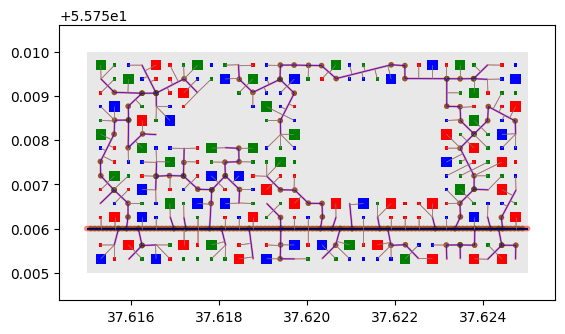

In [60]:
# --- Размещение локальных дорог ---

local_roads = []

#  Собираем все второстепенные дороги и главную в один объект (для поиска ближайшей точки)
all_secondary_and_main_roads = [main_road] + secondary_roads
all_secondary_and_main_roads = shapely.ops.unary_union(all_secondary_and_main_roads)

for obj in placed_objects:
    #  Находим ближайшую точку на второстепенных дорогах ИЛИ на главной
    nearest_point = shapely.ops.nearest_points(obj.centroid, all_secondary_and_main_roads)[1]

    #  Строим отрезок от центра объекта до ближайшей точки
    local_road = shapely.geometry.LineString([obj.centroid, nearest_point])

    #  Проверяем на пересечения (с другими ОБЪЕКТАМИ, но НЕ с дорогами!)
    intersects = False
    for other_obj in placed_objects:
        if other_obj != obj and local_road.intersects(other_obj.buffer(object_types_params[obj_type]["min_distance_deg"]/2)):  #  ДОБАВИЛИ .buffer()
            intersects = True
            #print(f"Локальная дорога от объекта {obj.centroid} пересекает другой объект") #Отладка
            break

    if not intersects:  # Добавляем дорогу, если нет пересечений
        local_roads.append(local_road)


# Добавляем локальные дороги в all_roads (буферизованные)
for road in local_roads:
    road_buffered = buffer_road(road, ROAD_TYPES["local"]["width_deg"])
    all_roads = shapely.ops.unary_union([all_roads, road_buffered])  # Добавляем к существующим дорогам

#--Визуализация (для отладки)--------
fig, ax = plt.subplots()
#gpd.GeoSeries(grid_points).plot(ax=ax, markersize=1, color='blue') # Точки сетки
gpd.GeoSeries([buildable_area]).plot(ax=ax, color="lightgray", alpha=0.5) #Зона застройки
gpd.GeoSeries([main_road]).plot(ax=ax, color="black") #Главная дорога

#  Дороги до буферизации
for road in secondary_roads:
    gpd.GeoSeries([road]).plot(ax=ax, color="blue", linewidth=0.5) #Второстепенные

for road in local_roads:
   gpd.GeoSeries([road]).plot(ax=ax, color="gray", linewidth=0.5) #Локальные

for intersection in intersections:
    gpd.GeoSeries([intersection]).plot(ax=ax, color="green", alpha=0.7) #Перекрестки

#  Все дороги (с буфером)
if not all_roads.is_empty:
    gpd.GeoSeries([all_roads]).plot(ax=ax, color="red", alpha=0.5)

# Здания
building_colors = {"residential": "red", "commercial": "blue", "park": "green"} #Словарь цветов
for obj, obj_type in zip(placed_objects, [list(OBJECT_TYPES.keys())[i%len(OBJECT_TYPES)] for i in range(len(placed_objects))]): # Добавили obj_type
        color = building_colors.get(obj_type, "gray") # default color
        gpd.GeoSeries([obj]).plot(ax=ax, color=color, label=obj_type)
#------------------------

# Установка пределов
minx, miny, maxx, maxy = buildable_area.bounds
ax.set_xlim(minx - max_building_size_deg*2, maxx + max_building_size_deg*2)
ax.set_ylim(miny - max_building_size_deg*2, maxy + max_building_size_deg*2)

plt.show()


In [61]:
# --- Генерация GeoJSON ---

# Создание списка Feature для ВСЕХ объектов (включая дороги)
all_features = []
obj_counter = 0

#  Здания и парки
for obj, obj_type in zip(placed_objects, [list(OBJECT_TYPES.keys())[i%len(OBJECT_TYPES)] for i in range(len(placed_objects))]):

    feature = {
        "type": "Feature",
        "properties": {
            "type": obj_type,
            "id": obj_counter
        },
        "geometry": shapely.geometry.mapping(obj)
    }
    obj_counter += 1
    all_features.append(feature)

#  Главная дорога
feature = {
    "type": "Feature",
    "properties": {
        "type": "road",
        "road_type": "main",
        "id": obj_counter
    },
    "geometry": shapely.geometry.mapping(main_road_buffered) #  Уже с буфером!
}
obj_counter += 1
all_features.append(feature)

#  Второстепенные дороги
for i, road in enumerate(secondary_roads):
    feature = {
        "type": "Feature",
        "properties": {
            "type": "road",
            "road_type": "secondary",
            "id": obj_counter + i
        },
        "geometry": shapely.geometry.mapping(road)  #  Без буфера!  Буфер будет в all_roads
    }
    all_features.append(feature)
obj_counter += len(secondary_roads)

#  Локальные дороги
for i, road in enumerate(local_roads):
    feature = {
        "type": "Feature",
        "properties": {
            "type": "road",
            "road_type": "local",
            "id": obj_counter + i
        },
        "geometry": shapely.geometry.mapping(road) #  Без буфера!
    }
    all_features.append(feature)
obj_counter += len(local_roads)

# Перекрестки
for i, intersection in enumerate(intersections):
    feature = {
        "type": "Feature",
         "properties": {
            "type": "road",
            "road_type": "intersection",
            "id": obj_counter + i
        },
        "geometry": shapely.geometry.mapping(intersection)
    }
    all_features.append(feature)

# Создание FeatureCollection
output_geojson = {
    "type": "FeatureCollection",
    "features": all_features
}

# Запись в файл
with open("output.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

print("GeoJSON файл сгенерирован: output.geojson")


GeoJSON файл сгенерирован: output.geojson


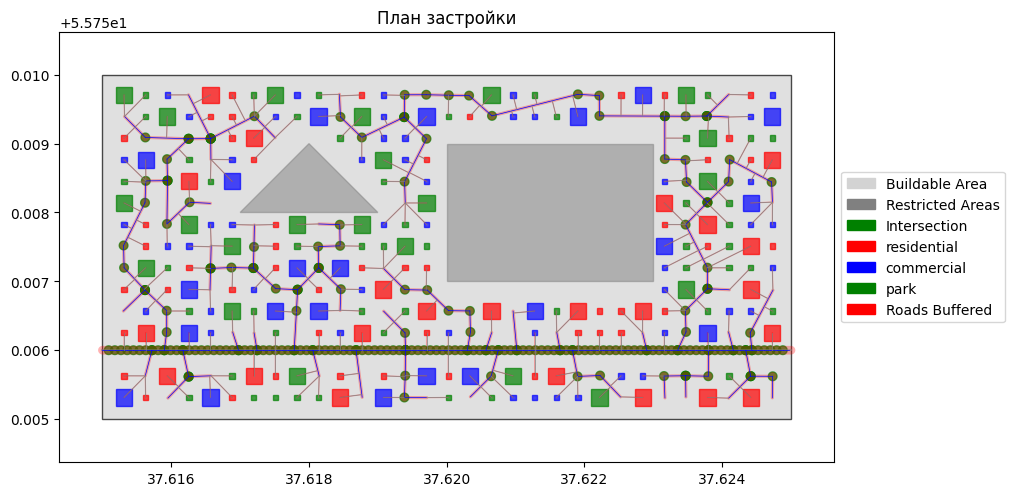

Изображение плана застройки сохранено в output.png


In [62]:
# --- Визуализация ---
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 10))

# Отрисовка зоны застройки
if isinstance(buildable_area, shapely.geometry.Polygon):
    polygon = mpatches.Polygon(list(buildable_area.exterior.coords), facecolor='lightgray', edgecolor='black', alpha=0.7)
    ax.add_patch(polygon)
buildable_area_patch = mpatches.Patch(color='lightgray', label='Buildable Area')


# Отрисовка зон с ограничениями
if restricted_areas is not None:
    for geom in restricted_areas.geoms:
        if isinstance(geom, shapely.geometry.Polygon):
            polygon = mpatches.Polygon(list(geom.exterior.coords), color='gray', alpha=0.5)
            ax.add_patch(polygon)
        elif isinstance(geom, shapely.geometry.LineString):
            line = mlines.Line2D(*zip(*geom.coords), color='gray', alpha=0.5)
            ax.add_line(line)

restricted_area_patch = mpatches.Patch(color='gray', label='Restricted Areas')


# Отрисовка размещенных объектов
legend_handles = [buildable_area_patch, restricted_area_patch]

#  Дороги (сначала небуферизованные)
for road in secondary_roads:
    line = mlines.Line2D(*zip(*road.coords), color="blue", linewidth=0.5, label="Secondary Road")
    ax.add_line(line)

for road in local_roads:
    line = mlines.Line2D(*zip(*road.coords), color="gray", linewidth=0.5, label="Local Road")
    ax.add_line(line)


for intersection in intersections:
    polygon = mpatches.Polygon(list(intersection.exterior.coords), color="green", alpha=0.7)
    ax.add_patch(polygon)
    legend_handles.append(mpatches.Patch(color='green', label='Intersection'))

#  Объекты
for obj, obj_type in zip(placed_objects, [list(OBJECT_TYPES.keys())[i%len(OBJECT_TYPES)] for i in range(len(placed_objects))]):
    color = OBJECT_TYPES[obj_type]["color"]
    if isinstance(obj, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(obj.exterior.coords), color=color, alpha=0.7)
        ax.add_patch(polygon)
        legend_handles.append(mpatches.Patch(color=color, label=obj_type))

# Дороги (одним объектом)
if not all_roads.is_empty:
    gpd.GeoSeries([all_roads]).plot(ax=ax, color="red", alpha=0.3, label = "Roads Buffered")
    legend_handles.append(mpatches.Patch(color='red', label='Roads Buffered'))


# Добавление легенды (без дубликатов)
unique_handles = []
unique_labels = []
for handle, label in zip(legend_handles, [h.get_label() for h in legend_handles]):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)


plt.legend(handles=unique_handles, labels=unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Установка заголовка
plt.title("План застройки")

# Установка пределов осей!
minx, miny, maxx, maxy = buildable_area.bounds
ax.set_xlim(minx - max_building_size_deg*2, maxx + max_building_size_deg*2)
ax.set_ylim(miny - max_building_size_deg*2, maxy + max_building_size_deg*2)

#  Сохраняем соотношение сторон!
ax.set_aspect('equal')  # <--- ПРОВЕРЬ, ЧТО ЭТО ЗДЕСЬ!

# Сохранение изображения
plt.savefig("output.png")

# Показ изображения
plt.show()

print("Изображение плана застройки сохранено в output.png")
